<a href="https://colab.research.google.com/github/arjunparmar/VIRTUON/blob/main/Harshit/Warping_Module(GAN%20Trail)%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install --upgrade neural_structured_learning

Requirement already up-to-date: neural_structured_learning in /usr/local/lib/python3.6/dist-packages (1.3.1)


In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras 
from tensorflow.keras.layers import Conv2D, concatenate, Dropout,MaxPool2D, MaxPooling2D, Conv2DTranspose, Activation, BatchNormalization,UpSampling2D, Add
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import neural_structured_learning as nsl

import glob
import imageio
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [4]:
im_height, im_width, im_channels = (128,128,3)
n_classes = 20
batch = 32

In [5]:
#Build the model
def conv_2d_block (x,n_filters,k_size = 3,batchnorm = False):
#1st layer
  x= Conv2D(filters=n_filters,kernel_size=(k_size,k_size) ,padding='same', kernel_initializer = 'he_normal')(x)
  if batchnorm:
    x= BatchNormalization()(x)
  x = Activation('relu')(x)
#2nd Layer
  x= Conv2D(filters=n_filters,kernel_size=(k_size,k_size) ,padding='same', kernel_initializer = 'he_normal')(x)
  if batchnorm:
    x= BatchNormalization()(x)
  x = Activation('relu')(x)

  return x

In [6]:
def clothing_encoder(inputs, n_filters=16,conv_k_size=3,pool_size=2,batchnorm=True,dropout=.2):

  c1 = conv_2d_block(inputs,n_filters*1,conv_k_size,batchnorm)  
  p1 = MaxPool2D(pool_size=(pool_size,pool_size))(c1)
  p1 = Dropout(dropout)(p1)
  
  c2 = conv_2d_block(p1,n_filters*2,conv_k_size,batchnorm)  
  p2 = MaxPool2D(pool_size=(pool_size,pool_size))(c2)
  p2 = Dropout(dropout)(p2)

  c3 = conv_2d_block(p2,n_filters*4,conv_k_size,batchnorm)  
  p3 = MaxPool2D(pool_size=(pool_size,pool_size))(c3)
  p3 = Dropout(dropout)(p3)

  c4 = conv_2d_block(p3,n_filters*8,conv_k_size,batchnorm)  
  p4 = MaxPool2D(pool_size=(pool_size,pool_size))(c4)
  p4 = Dropout(dropout)(p4)

  c5 = conv_2d_block(p4,n_filters*16,conv_k_size,batchnorm)  
  p5 = MaxPool2D(pool_size=(pool_size,pool_size))(c5)
  p5 = Dropout(dropout)(p5)

  c6 = conv_2d_block(p5,n_filters*32,conv_k_size,batchnorm)  
  p6 = MaxPool2D(pool_size=(pool_size,pool_size))(c6)
  p6 = Dropout(dropout)(p6)

  c7 = conv_2d_block(p6,n_filters*64,conv_k_size,batchnorm)
 

  a =  tf.keras.layers.UpSampling2D(size=(8, 8), interpolation="nearest")(c7)

  c8 = conv_2d_block(a,n_filters*32,conv_k_size,batchnorm)  


  return c8

In [7]:
def pose_encoder(inputs, n_filters=16,conv_k_size=3,pool_size=2,batchnorm=True,dropout=.2):

  c01 = conv_2d_block(inputs,n_filters*1,conv_k_size,batchnorm)  
  p01 = MaxPool2D(pool_size=(pool_size,pool_size))(c01)
  p01 = Dropout(dropout)(p01)
  
  c02 = conv_2d_block(p01,n_filters*2,conv_k_size,batchnorm)  
  p02 = MaxPool2D(pool_size=(pool_size,pool_size))(c02)
  p02 = Dropout(dropout)(p02)

  c03 = conv_2d_block(p02,n_filters*4,conv_k_size,batchnorm)  
  p03 = MaxPool2D(pool_size=(pool_size,pool_size))(c03)
  p03 = Dropout(dropout)(p03)

  c04 = conv_2d_block(p03,n_filters*8,conv_k_size,batchnorm)  
 

  c05 = conv_2d_block(c04,n_filters*16,conv_k_size,batchnorm)  
  

  c06 = conv_2d_block(c05,n_filters*32,conv_k_size,batchnorm)
 
  return c06

In [8]:
def res_identity(x, filters): 
  #renet block where dimension doesnot change.
  #The skip connection is just simple identity conncection
  #we will have 3 blocks and then input will be added

  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  #first block 
  x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  #second block # bottleneck (but size kept same with padding)
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # third block activation used after adding the input
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
  x = BatchNormalization()(x)
  # x = Activation('relu')(x)
  
  # add the input 
  x = Add()([x, x_skip])
  x = Activation('relu')(x)

  return x

def res_conv(x, s, filters):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid')(x)
  # when s = 2 then it is like downsizing the feature map
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # second block
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  #third block
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
  x = BatchNormalization()(x)

  # shortcut 
  x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid')(x_skip)
  x_skip = BatchNormalization()(x_skip)

  # add 
  x = Add()([x, x_skip])
  x = Activation('relu')(x)

  return x

In [9]:
def res_block(x, s, filters):

  # input_im = Input(shape=(x.shape[1], x.shape[2], x.shape[3])) # cifar 10 images size
  # x = ZeroPadding2D(padding=(3, 3))(input_im)

  # # 1st stage
  # # here we perform maxpooling, see the figure above

  # x = BatchNormalization()(x)
  # x = Activation(activations.relu)(x)


  #2nd stage 
  # frm here on only conv block and identity block, no pooling
  x = res_conv(x, s, filters)
  x = res_identity(x, filters=(64, 512))
  x = res_identity(x, filters=(64, 512))

  # 3rd stage

  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))


  # 4th stage

  x = res_identity(x, filters=(256, 512))
  x = res_identity(x, filters=(256, 512))
  x = res_identity(x, filters=(256, 512))
  x = res_identity(x, filters=(256, 512))
  x = res_identity(x, filters=(256, 512))

  # 5th stage

  x = res_identity(x, filters=(512, 512))
  x = res_identity(x, filters=(512, 512))

  # ends with average pooling and dense connection

  # x = AveragePooling2D((2, 2), padding='same')(x)

  # x = Flatten()(x)
  # x = Dense(len(class_types), activation='softmax', kernel_initializer='he_normal')(x) #multi-class

  return x

In [10]:
#cloth decoder 
def clothing_decoder(inputs,n_filters=16,conv_k_size=3,pool_size=2,batchnorm=True,dropout=.2):
  u6 = Conv2DTranspose(filters=n_filters *16 ,kernel_size=(3,3), strides=(2,2),padding='same')(inputs)
  u6 = Dropout(dropout)(u6)
  c7 = conv_2d_block(u6,n_filters *16 , conv_k_size,batchnorm)

  u7 = Conv2DTranspose(filters=n_filters *8,kernel_size=(3,3), strides=(2,2),padding='same')(c7)
  u7 = Dropout(dropout)(u7)
  c8 = conv_2d_block(u7,n_filters *8 , conv_k_size,batchnorm)

  u8 = Conv2DTranspose(filters=n_filters *4,kernel_size=(3,3), strides=(2,2),padding='same')(c8)
  u8 = Dropout(dropout)(u8)
  c9 = conv_2d_block(u8,n_filters *4, conv_k_size,batchnorm)

  c10 = Conv2D(filters=n_classes, kernel_size=(1,1),activation='softmax')(c9)
  
  return c10

In [11]:
def warp(cloth_input, pose_input):
    cloth = clothing_encoder(cloth_input)
    pose = pose_encoder(pose_input)
    both = concatenate([cloth, pose])
    resnet = res_block(both, 1, (64,512))
    output = clothing_decoder(resnet)

    return Model(inputs = (cloth_input, pose_input), outputs = output, name = "Warping_Module")

In [12]:
def dis(input, n_filters=16,k_size=3,pool_size=2,batchnorm=True,dropout=.2):
    x = Conv2D(filters=64,kernel_size=(k_size,k_size) ,padding='same', kernel_initializer = 'he_normal')(input)
    x = MaxPool2D(pool_size = (pool_size, pool_size))(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=64,kernel_size=(k_size,k_size) ,padding='same', kernel_initializer = 'he_normal')(x)
    x = MaxPool2D(pool_size = (pool_size, pool_size))(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=64,kernel_size=(k_size,k_size) ,padding='same', kernel_initializer = 'he_normal')(x)
    x = MaxPool2D(pool_size = (pool_size, pool_size))(x)
    x = Activation('relu')(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = tf.keras.layers.Dense(1, activation = 'sigmoid', kernel_initializer = 'he_normal')(x)

    return Model(inputs = input, outputs = x, name = 'Discriminator')

In [13]:
discriminator = dis(Input((im_height, im_width, n_classes)))

In [14]:
cloth = Input((im_height, im_width, n_classes), name = "cloth")
pose = Input((im_height, im_width, im_channels), name = 'pose')
generator = warp(cloth, pose)

In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [16]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
BUFFER_SIZE = 60000
BATCH_SIZE = batch

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [27]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    # display.clear_output(wait=True)
    # generate_and_save_images(generator,
    #                          epoch + 1,
    #                          seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
#   display.clear_output(wait=True)
#   generate_and_save_images(generator,
#                            epochs,
#                            seed)

In [18]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, im_height, im_width, n_classes])
    noise_1 = tf.random.normal([BATCH_SIZE, im_height, im_width, im_channels])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images =generator((noise, noise_1), training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [19]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [20]:
x_train_pos = np.load("/content/drive/Shareddrives/Virtuon/Clothing Coparsing/dataset/pos_train.npy")
x_train_seg = np.load("/content/drive/Shareddrives/Virtuon/Clothing Coparsing/dataset/seg_train_argmax.npy")
x_valid_pos = np.load("/content/drive/Shareddrives/Virtuon/Clothing Coparsing/dataset/x_test.npy")
x_valid_seg = np.load("/content/drive/Shareddrives/Virtuon/Clothing Coparsing/dataset/seg_test_argmax.npy")

In [21]:
x_train_seg_1 = tf.one_hot(x_train_seg, depth = n_classes)
x_valid_seg_1 = tf.one_hot(x_valid_seg, depth = n_classes)

In [22]:
IMG_SIZE = 128

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.experimental.preprocessing.RandomFlip("vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
#   tf.keras.layers.experimental.preprocessing.RandomCrop(0.2,0.2)
])

In [23]:
def preprocessing(pos, seg):
    seg_1 = data_augmentation(seg)
    pos = tf.image.resize(pos, [im_height, im_width])
    seg = tf.image.resize(seg, [im_height, im_width])
    return (seg_1, pos), seg

In [24]:
def generator_train():
    while True:
        for i in range(0,len(x_train_pos),batch):
            if (i + batch < len(x_train_pos)):
                pos = x_train_pos[i:i+batch]
                seg = x_train_seg_1[i:i+batch]
                yield preprocessing(pos, seg)
            else:
                last = len(x_train_pos)
                pos = x_train_pos[i:last]
                seg = x_train_seg_1[i:last]
                yield preprocessing(pos, seg)

In [25]:
def generator_valid():
    while True:
        for i in range(0,len(x_valid_pos),batch):
            if (i + batch < len(x_valid_pos)):
                pos = x_valid_pos[i:i+batch]
                seg = x_valid_seg_1[i:i+batch]
                yield preprocessing(pos, seg)
            else:
                last = len(x_valid_pos)
                pos = x_valid_pos[i:last]
                seg = x_valid_seg_1[i:last]
                yield preprocessing(pos, seg)

In [29]:
x_train_seg_aug = data_augmentation(x_train_seg_1[0:batch])
train( tf.reshape(x_train_seg_aug, (1,32,128,128,20)), 1000)


Time for epoch 1 is 0.4660158157348633 sec
Time for epoch 2 is 0.5252277851104736 sec
Time for epoch 3 is 0.5299828052520752 sec
Time for epoch 4 is 0.5245494842529297 sec
Time for epoch 5 is 0.5277807712554932 sec
Time for epoch 6 is 0.5262613296508789 sec
Time for epoch 7 is 0.5305254459381104 sec
Time for epoch 8 is 0.527226448059082 sec
Time for epoch 9 is 0.5285890102386475 sec
Time for epoch 10 is 0.5282011032104492 sec
Time for epoch 11 is 0.5311031341552734 sec
Time for epoch 12 is 0.5289947986602783 sec
Time for epoch 13 is 0.528656005859375 sec
Time for epoch 14 is 0.526566743850708 sec
Time for epoch 15 is 0.530325174331665 sec
Time for epoch 16 is 0.5279712677001953 sec
Time for epoch 17 is 0.5310816764831543 sec
Time for epoch 18 is 0.5300207138061523 sec
Time for epoch 19 is 0.5329864025115967 sec
Time for epoch 20 is 0.5281214714050293 sec
Time for epoch 21 is 0.5311717987060547 sec
Time for epoch 22 is 0.5298583507537842 sec
Time for epoch 23 is 0.5320594310760498 sec
T

KeyboardInterrupt: ignored

In [33]:
result = generator.predict(( tf.image.resize(x_train_seg_1[11:12], [im_height, im_width]), tf.image.resize(x_train_pos[11:12], [im_height, im_width]) ))

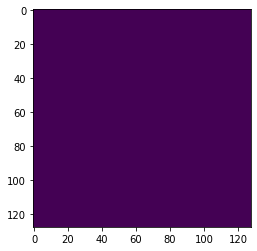

In [36]:
plt.imshow()

In [37]:
np.unique(tf.math.argmax(result[0], axis = -1))

array([7])